In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

pd.set_option('display.max_colwidth', None)  # or use 0 for older pandas versions


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadakbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohammadakbari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammadakbari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

# Load data
df = pd.read_csv('../data/trials.csv')
df.head()

# Check for nulls
print(df.isnull().sum())


nctid          0
description    0
label          0
dtype: int64


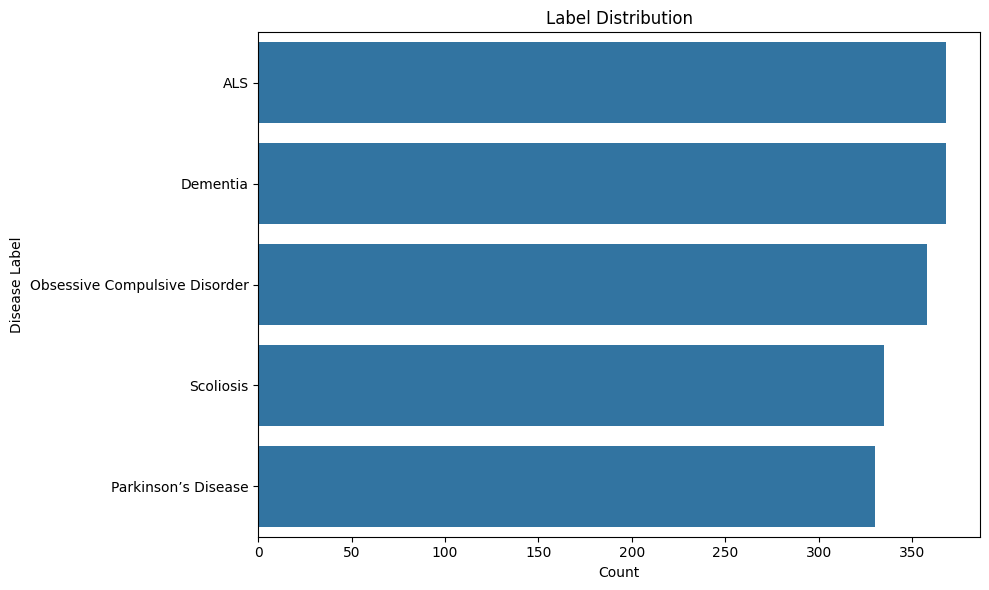

In [3]:

# Label distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index)
plt.title('Label Distribution')
plt.xlabel('Count')
plt.ylabel('Disease Label')
plt.tight_layout()
plt.show()


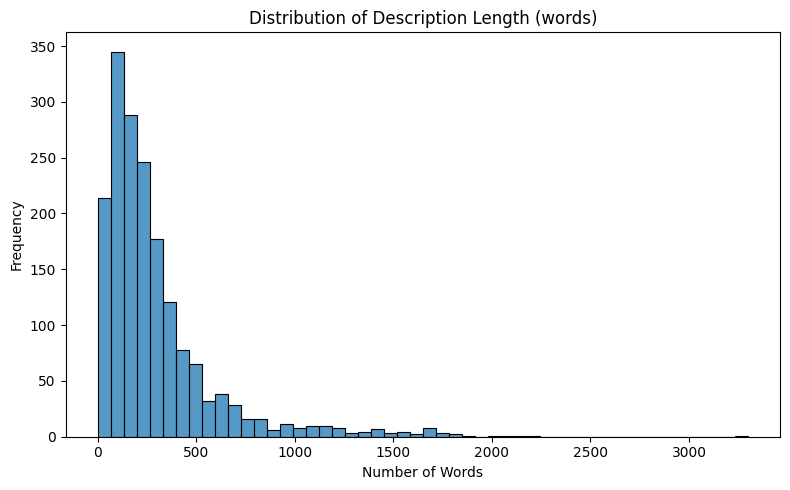

In [4]:

# Description length
df['desc_len'] = df['description'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,5))
sns.histplot(df['desc_len'], bins=50)
plt.title('Distribution of Description Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [5]:
df['description'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [6]:


# Preload tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Sample medical abbreviation dictionary
ABBREVIATION_MAP = {
    'OCD': 'Obsessive Compulsive Disorder',
    'ALS': 'Amyotrophic Lateral Sclerosis',
    'PD': 'Parkinsons Disease',
    'COPD': 'Chronic Obstructive Pulmonary Disease',
    'AD': 'Alzheimers Disease',
    # Add more based on UMLS/SNOMED if available
}

def expand_abbreviation(word):
    """Expand a word using ABBREVIATION_MAP if it exists."""
    return ABBREVIATION_MAP.get(word.upper(), word)

def preprocess_text(text, mode='expand'):
    """
    Preprocess clinical trial text with optional abbreviation expansion.

    Modes:
    - 'normal': standard lowercase cleanup
    - 'smart': preserve all-uppercase words
    - 'expand': expand medical abbreviations using ABBREVIATION_MAP
    """
    words = text.split()
    processed = []

    for word in words:
        if mode == 'smart':
            if word.isupper():
                processed.append(word)
            else:
                processed.append(word.lower())
        elif mode == 'expand':
            expanded = expand_abbreviation(word)
            processed.append(expanded.lower())
        else:  # 'normal'
            processed.append(word.lower())

    text = ' '.join(processed)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    return ' '.join(tokens)


In [7]:
# Apply text preprocessing with abbreviation expansion
df['clean_text'] = df['description'].apply(lambda x: preprocess_text(x, mode='normal'))

df[['description', 'clean_text']].head()

,description,clean_text
0,MND is often referred to as amyotrophic lateral sclerosis (ALS) or Lou Gehrig's disease.,mnd often referred amyotrophic lateral sclerosis al lou gehrig disease
1,"OBJECTIVE:||The causes of sporadic motor neuron diseases, primary lateral sclerosis (PLS) and amyotrophic lateral sclerosis (ALS) are unknown. Genes have been identified for some forms of familial motor neuron diseases. We don't know whether genes also play a role in sporadic motor neuron disease, for example through risk-factor genes or by the interaction of multiple genes as a complex genetic disorder. Identification of genetic contributions to sporadic motor neuron diseases requires analysis of DNA from patients.||The goal of this protocol is to collect blood samples from patients with motor neuron disease for creation of cell lines to bank in a repository created through an NINDS initiative. The cell lines will be used for DNA extraction. The repository provides anonymized samples of patient DNA or cell lines to investigators who are seeking to define genetic causes, contributions, and susceptibilities to neurological disorders. DNA and cell lines created from the blood sample are stripped of patient identifiers and stored indefinitely. A limited amount of clinical data, termed the clinical data elements, will be available for each coded sample. The samples will only be available for research. The results of testing will not be communicated to the patient.||STUDY POPULATION:||All patients will be enrolled in a primary protocol for the study of motor neuron diseases at NIH. This protocol will serve as a secondary protocol for sample collection and reporting of clinical data elements. Patients with Primary lateral sclerosis must meet the diagnostic criteria for PLS proposed by Pringle and patients with ALS must fulfill the revised El Escorial criteria for probable or definite ALS.||DESIGN:||Determination of diagnosis and eligibility will be carried out as part of the primary protocol. Patients will be informed of the DNA sample repository and its purpose. After informed consent is obtained, 2 tubes of blood will be drawn and assigned a unique identifier code. The coded samples, and a clinical data element form will then be sent to the repository, which will extract DNA and prepare cell lines. The identities of the subjects will not be stored. An aliquot of the sample will be forwarded to the associate investigator to look for disease associations with genetic markers.||OUTCOME MEASURES:||There is no specific outcome measure for this protocol. The samples will be made accessible to a wide variety of researchers seeking to determine the causes of motor neuron diseases and other neurological disorders through the repository's contract with NINDS.",objectivethe cause sporadic motor neuron disease primary lateral sclerosis pls amyotrophic lateral sclerosis al unknown gene identified form familial motor neuron disease dont know whether gene also play role sporadic motor neuron disease example riskfactor gene interaction multiple gene complex genetic disorder identification genetic contribution sporadic motor neuron disease requires analysis dna patientsthe goal protocol collect blood sample patient motor neuron disease creation cell line bank repository created ninds initiative cell line used dna extraction repository provides anonymized sample patient dna cell line investigator seeking define genetic cause contribution susceptibility neurological disorder dna cell line created blood sample stripped patient identifier stored indefinitely limited amount clinical data termed clinical data element available coded sample sample available research result testing communicated patientstudy populationall patient enrolled primary protocol study motor neuron disease nih protocol serve secondary protocol sample collection reporting clinical data element patient primary lateral sclerosis must meet diagnostic criterion pls proposed pringle patient al must fu

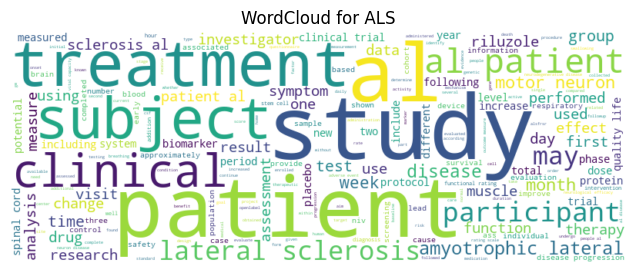

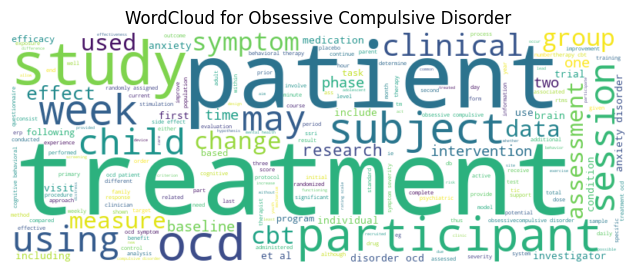

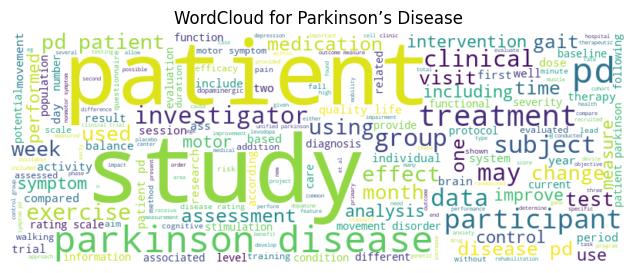

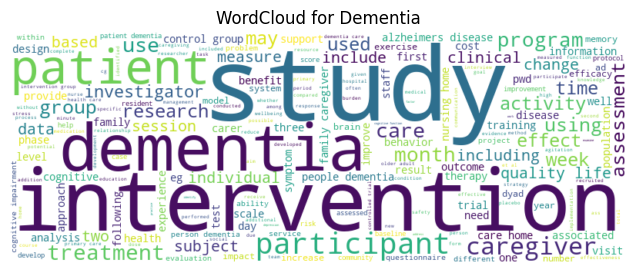

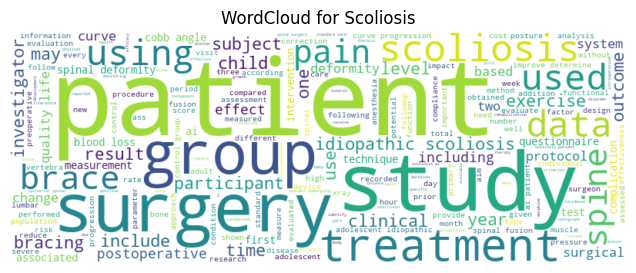

In [8]:

# Visualisation: WordCloud per label
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['clean_text'])
    wc = WordCloud(width=800, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10, 3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {label}')
    plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Assuming df has a 'clean_text' column for the processed text and a 'label' column for target labels
X = df['clean_text']
y = df['label']

# Split the data into Train, Validation, and Test sets (Stratified to maintain class distribution)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit the vectorizer on the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)


In [10]:
from sklearn.naive_bayes import MultinomialNB

def train_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, y_val):
    # Initialize the model
    model = MultinomialNB()
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_tfidf)
    
    # Evaluate model performance
    print("Naive Bayes - Validation Performance:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    
    return model


In [11]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X_train_tfidf, y_train, X_val_tfidf, y_val):
    # Initialize the model
    model = LogisticRegression(max_iter=1000, random_state=42)
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_tfidf)
    
    # Evaluate model performance
    print("Logistic Regression - Validation Performance:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    
    return model


In [12]:
from sklearn.svm import SVC

def train_svm(X_train_tfidf, y_train, X_val_tfidf, y_val):
    # Initialize the model
    model = SVC(kernel='linear', random_state=42)
    
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_tfidf)
    
    # Evaluate model performance
    print("SVM - Validation Performance:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    
    return model


In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

def fine_tune_bert(X_train, y_train, X_val, y_val, model_name="bert-base-uncased"):
    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Tokenize the data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
    val_encodings = tokenizer(list(X_val), truncation=True, padding=True)

    # Convert to torch datasets
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(y_train.values)
    )
    
    val_dataset = torch.utils.data.TensorDataset(
        torch.tensor(val_encodings['input_ids']),
        torch.tensor(val_encodings['attention_mask']),
        torch.tensor(y_val.values)
    )

    # Load BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(y_train.unique()))

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy="epoch",
        logging_dir='./logs',
        logging_steps=10,
        save_steps=10,
        load_best_model_at_end=True
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print("BERT - Validation Performance:")
    print("Accuracy:", eval_results['eval_accuracy'])
    print("F1 Score:", eval_results['eval_f1'])
    
    return model


/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/envs/nlp/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
# Train Naive Bayes
nb_model = train_naive_bayes(X_train_tfidf, y_train, X_val_tfidf, y_val)

# Train Logistic Regression
lr_model = train_logistic_regression(X_train_tfidf, y_train, X_val_tfidf, y_val)

# Train SVM
svm_model = train_svm(X_train_tfidf, y_train, X_val_tfidf, y_val)

# For Fine-Tuned BERT (if you choose the advanced option)
# bert_model = fine_tune_bert(X_train, y_train, X_val, y_val)


Naive Bayes - Validation Performance:
Accuracy: 0.875
Classification Report:
                                precision    recall  f1-score   support

                          ALS       0.78      0.95      0.85        55
                     Dementia       0.84      0.85      0.85        55
Obsessive Compulsive Disorder       0.91      0.91      0.91        54
          Parkinson’s Disease       0.92      0.73      0.82        49
                    Scoliosis       0.98      0.92      0.95        51

                     accuracy                           0.88       264
                    macro avg       0.89      0.87      0.87       264
                 weighted avg       0.88      0.88      0.87       264

Confusion Matrix:
 [[52  2  0  1  0]
 [ 4 47  3  1  0]
 [ 2  2 49  1  0]
 [ 7  3  2 36  1]
 [ 2  2  0  0 47]]
Logistic Regression - Validation Performance:
Accuracy: 0.9204545454545454
Classification Report:
                                precision    recall  f1-score   support


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import umap
from sklearn.manifold import TSNE

def evaluate_model(model, X_val_tfidf, y_val, X_val, y_val_labels, model_name="Model"):
    # 1. Predict on Validation Set
    y_val_pred = model.predict(X_val_tfidf)

    # 2. Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred, labels=y_val_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_val_labels, yticklabels=y_val_labels)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 3. Classification Report
    print(f"{model_name} - Classification Report:\n", classification_report(y_val, y_val_pred))

    # 4. Visualize Misclassified Examples
    misclassified_indices = np.where(y_val != y_val_pred)[0]
    misclassified_samples = X_val.iloc[misclassified_indices]
    misclassified_labels = y_val.iloc[misclassified_indices]
    misclassified_preds = y_val_pred[misclassified_indices]
    
    print(f"Misclassified Examples:")
    for i in range(min(5, len(misclassified_samples))):  # Show up to 5 misclassified samples
        print(f"True Label: {misclassified_labels.iloc[i]}, Predicted Label: {misclassified_preds[i]}")
        print(f"Text: {misclassified_samples.iloc[i]}")
        print("-" * 100)


    return y_val_pred



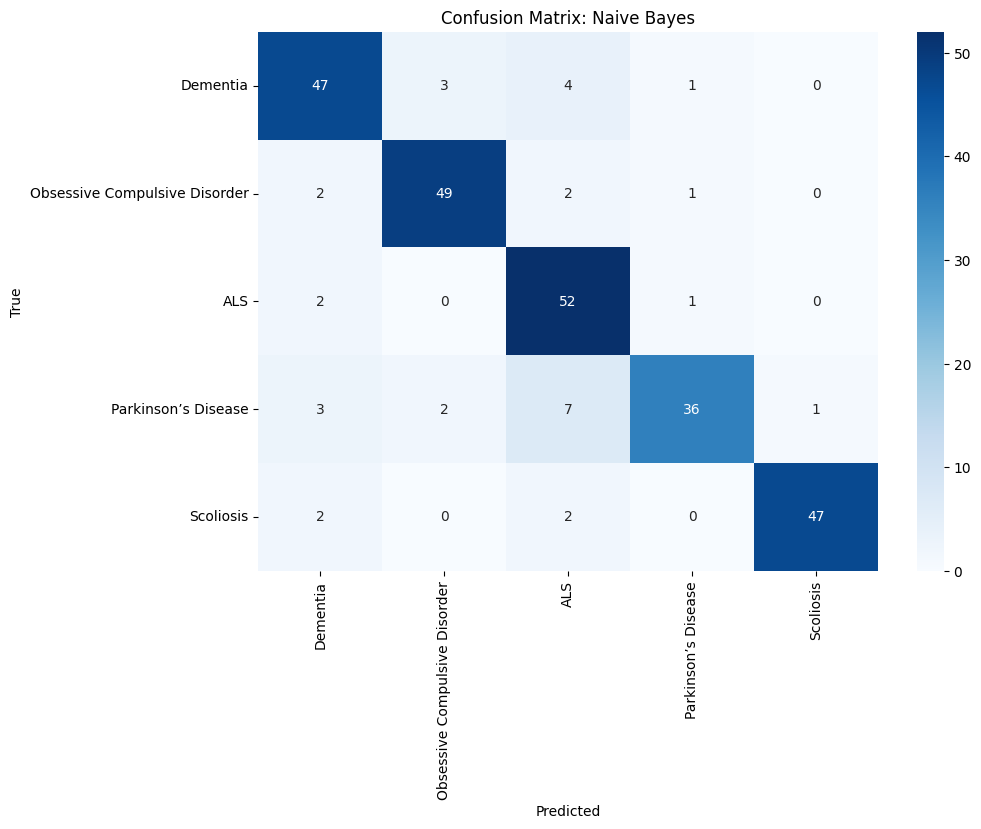

Naive Bayes - Classification Report:
                                precision    recall  f1-score   support

                          ALS       0.78      0.95      0.85        55
                     Dementia       0.84      0.85      0.85        55
Obsessive Compulsive Disorder       0.91      0.91      0.91        54
          Parkinson’s Disease       0.92      0.73      0.82        49
                    Scoliosis       0.98      0.92      0.95        51

                     accuracy                           0.88       264
                    macro avg       0.89      0.87      0.87       264
                 weighted avg       0.88      0.88      0.87       264

Misclassified Examples:
True Label: Dementia, Predicted Label: ALS
Text: proposal evaluate effect bosutinib bosulif pfizer® treatment fdaapproved tyrosine kinase inhibitor target cabelson abl src tyrosine kinase patient dlb investigator demonstrated safety efficacy compound preclinical animal model others shown similar

AttributeError: 'NoneType' object has no attribute 'split'

In [18]:
# Evaluate Naive Bayes Model
y_val_pred_nb = evaluate_model(nb_model, X_val_tfidf, y_val, X_val, y_val.unique(), "Naive Bayes")


In [ ]:
y_val_pred_lr = evaluate_model(lr_model, X_val_tfidf, y_val, X_val, y_val.unique(), "Logistic Regression")


In [ ]:
y_val_pred_svm = evaluate_model(svm_model, X_val_tfidf, y_val, X_val, y_val.unique(), "SVM")
